In [376]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import PIL
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [377]:
data_dir = pathlib.Path("Data/Synthetic")

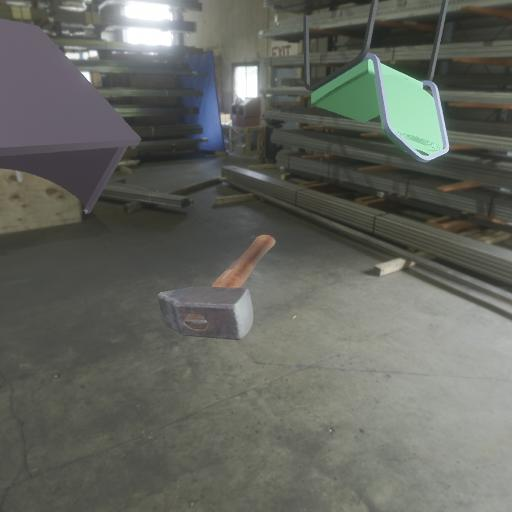

In [378]:
hammers = list(data_dir.glob('Hammer/*'))
PIL.Image.open(str(hammers[0]))

In [379]:
batch_size = 40
img_height = 256
img_width = 256

In [380]:
# Split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 79328 files belonging to 4 classes.
Using 63463 files for training.


In [381]:
# Split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 79328 files belonging to 4 classes.
Using 15865 files for validation.


In [382]:
class_names = train_ds.class_names
print(class_names)

['CombWrench', 'Hammer', 'Screwdriver', 'Wrench']


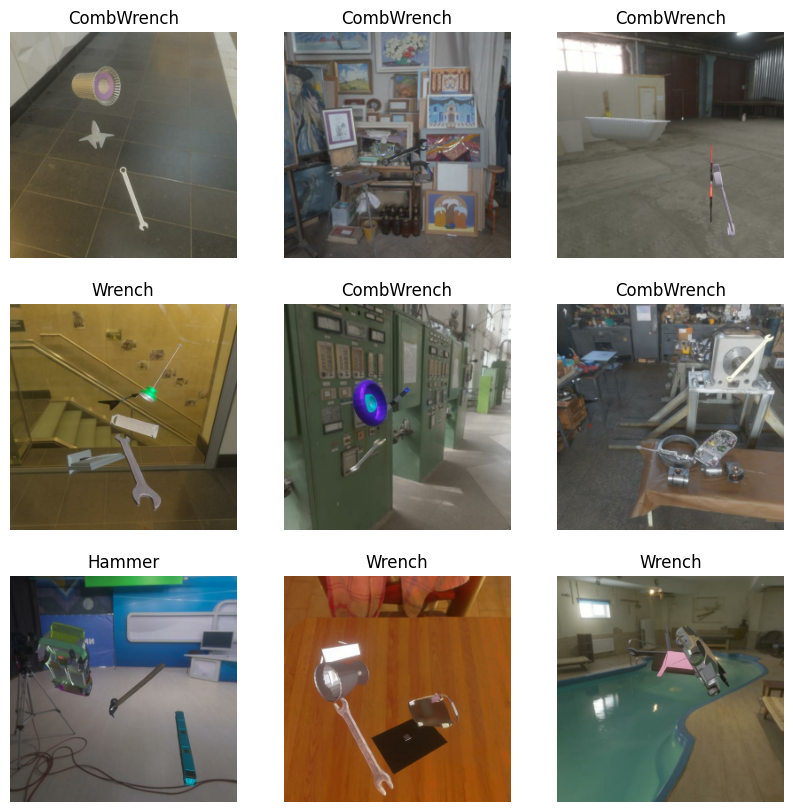

In [383]:
plt.figure(figsize=(10, 10))
# Take image from train_ds
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [384]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(40, 256, 256, 3)
(40,)


In [385]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocess Data

In [386]:
# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [387]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# Sparete as image and label
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("minumum value:",np.min(first_image), "maximum values: ",np.max(first_image))

minumum value: 0.04019608 maximum values:  1.0


# Neural Network

In [388]:
num_classes = len(class_names)

# Build model layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [389]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [390]:
model.summary()

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_39 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 128, 128, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,836 (32.09 MB)

 Trainable params: 8,412,836 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

# Neural Network (Training)

In [363]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step - accuracy: 0.2009 - loss: 5.6225 - val_accuracy: 0.3750 - val_loss: 1.5998
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.2286 - loss: 1.6057 - val_accuracy: 0.2750 - val_loss: 1.3964
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.2750 - loss: 1.3822 - val_accuracy: 0.2500 - val_loss: 1.3759
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.2987 - loss: 1.3518 - val_accuracy: 0.2500 - val_loss: 1.3981
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.4033 - loss: 1.2614 - val_accuracy: 0.2500 - val_loss: 1.4008
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.6112 - loss: 0.9675 - val_accuracy: 0.1250 - val_loss: 1.5782
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.5285 - loss: 1.0760 - val_accuracy: 0.2500 - val_loss: 1.7040
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.7318 - loss: 0.6552 - val_accuracy: 0.2000 - val_loss:

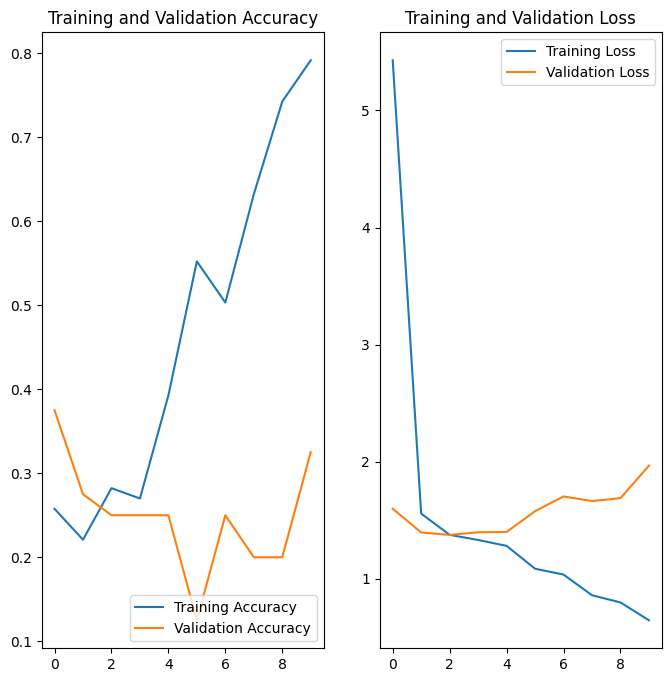

In [364]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [391]:
# Create augmentation sequentions
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

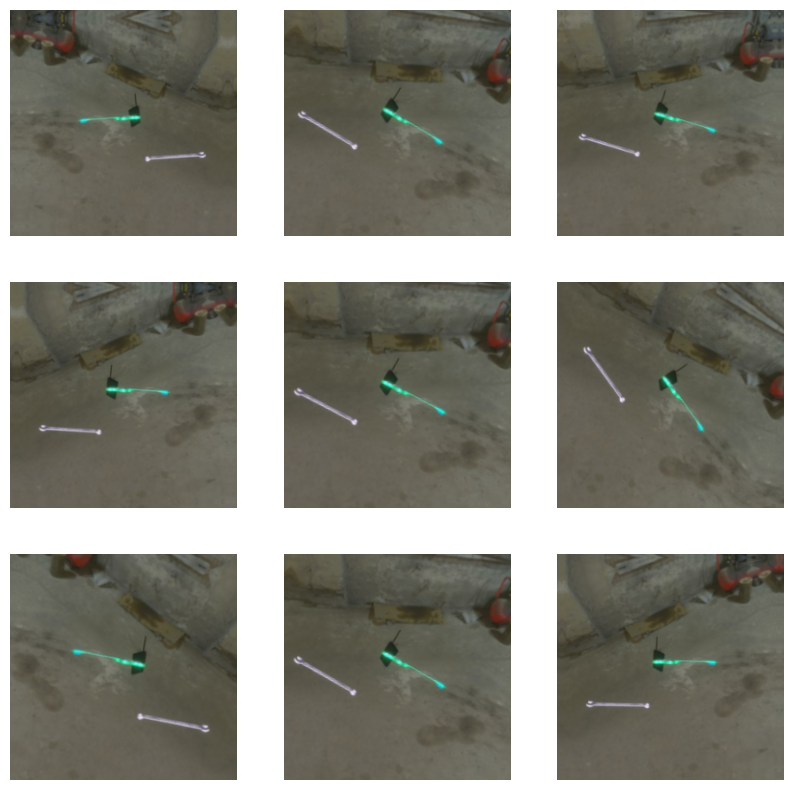

In [392]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Data Augmentation and Dropout

In [393]:
# Build model layers
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [394]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [395]:
# dummy_input = np.zeros((1, img_height, img_width, 3))
# model.build(input_shape=dummy_input.shape)

In [396]:
model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_50 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_40 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_119               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [397]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 625s 319ms/step - accuracy: 0.3069 - loss: 1.3622 - val_accuracy: 0.3759 - val_loss: 1.2614
Epoch 2/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 455s 286ms/step - accuracy: 0.3960 - loss: 1.2519 - val_accuracy: 0.4033 - val_loss: 1.2359
Epoch 3/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 501s 286ms/step - accuracy: 0.4171 - loss: 1.2219 - val_accuracy: 0.4153 - val_loss: 1.2260
Epoch 4/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 457s 288ms/step - accuracy: 0.4210 - loss: 1.2063 - val_accuracy: 0.4173 - val_loss: 1.2163
Epoch 5/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 457s 288ms/step - accuracy: 0.4308 - loss: 1.1895 - val_accuracy: 0.4258 - val_loss: 1.2203
Epoch 6/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 500s 315ms/step - accuracy: 0.4404 - loss: 1.1790 - val_accuracy: 0.4199 - val_loss: 1.2309
Epoch 7/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 446s 281ms/step - accuracy: 0.4449 - loss: 1.1713 - val_accuracy: 0.4269 - val_loss: 1.2176
Epoch 8/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 455s 287ms/step - ac

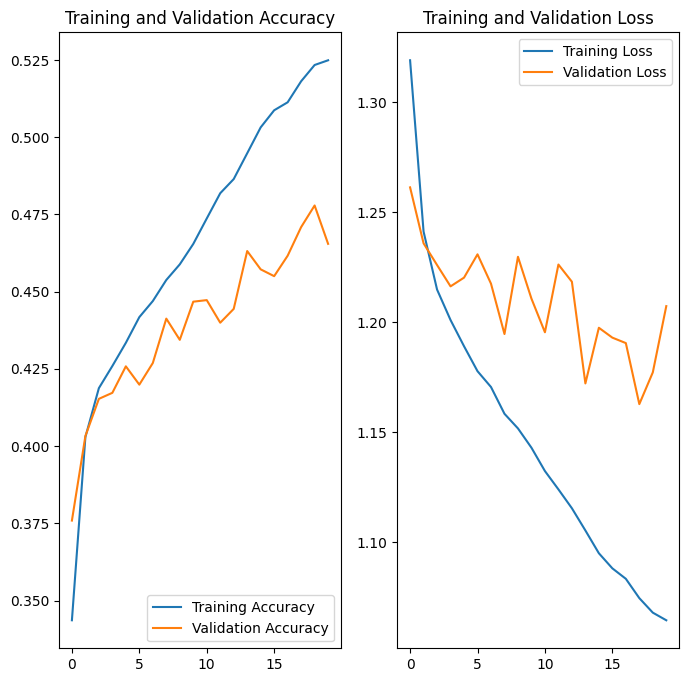

In [398]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [373]:
image_path = "Data/Real/Hammer/IMG_0682.JPEG"
img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
# image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
This image most likely belongs to Hammer with a 41.67 percent confidence.


In [399]:
folder_path = "Data/Synthetic/Hammer"
correct = 0

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    img = tf.keras.utils.load_img(file_path, target_size=(img_height, img_width))
    # image to array
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    #make prediction
    predictions = model.predict(img_array)
    #get score
    score = tf.nn.softmax(predictions[0])

    if (class_names[np.argmax(score)] == "Hammer"):
        correct += 1

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
print(f"Amount of correct classified: {correct}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
This image most likely belongs to Hammer with a 42.54 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
This image most likely belongs to Hammer with a 39.48 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This image most likely belongs to Hammer with a 63.10 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image most likely belongs to Hammer with a 44.32 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This image most likely belongs to Screwdriver with a 45.00 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This image most likely belongs to Hammer with a 50.94 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
This image most likely belongs to Screwdriver with a 37.59 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image most likely belongs to Wrench with a 58.73 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This image most likely belongs to Wrench with a 40.98 p

# Save model

In [400]:
model.save(os.path.join("models", "Synthetic_data_augmentation.keras"))